# Классификация движения фехтовальщика

In [1]:
# путь к папке fencing_signals
way_folder = 'fencing_signals/'

# пусть к папкам с записями для каждого участника
exp = ['Cherkasova_20_1/', 
       'Cherkasova_20_2/', 
       'Sugkoeva_17/', 
       'Zushko_18/'
      ]

#частота дискритизации устройства
fs = 125

#части тела, к которым закреплены датчики
body_part = ["передней руке", "груди", "передней ноге", "задней ноге"]

#выполняемые действия
fencing_move = ['рукой', 'шагом', 'выпадом']

# сохранение графиков
save = False

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import pandas as pd
import numpy as np
import os
import math
import warnings
warnings.filterwarnings('ignore')
from scipy.signal import find_peaks

# Опиcание используемых функций

In [14]:
def read_data(file_names, column_names):
    """Чтение записанных данных"""
    
    dfs = []
    for file_name, column_name in zip(file_names, column_names):
        df = pd.read_csv(file_name, header=None, delimiter="\t", decimal=",", comment=";", names=[column_name])
        df_rounded = df.round(2)
        dfs.append(df_rounded)
    
    dfs_concated = []
    for i in range(4):
        df = pd.concat([dfs[i], dfs[i + 4], dfs[i + 8]], axis=1)
        dfs_concated.append(df)
    return dfs_concated

        

def creation_of_dfs(way_folder, experimental, folder):
    """Создание датафреймов с данными гироскопа по осям"""
    
    folder_path = f"{way_folder}{experimental}{folder}CSV_Export"
    file_names = ["Hyro Y_9.csv", "Hyro X_11.csv", "Hyro Z_16.csv", "Hyro X_17.csv", 
                  "Hyro X_8.csv", "Hyro Z_13.csv", "Hyro X_14.csv", "Hyro Z_19.csv",
                  "Hyro Z_10.csv", "Hyro Y_12.csv", "Hyro Y_15.csv", "Hyro Y_18.csv"]
    
    file_paths = [os.path.join(folder_path, file_name) for file_name in file_names]
    column_names = ["x", "x", "x", "x", "y", "y", "y", "y", "z", "z", "z", "z"]   
    dfs = read_data(file_paths, column_names)
    
    #при записи сигналов датчики были закреплены в определнных позициях, 
    #чтобы система координат для всех датчиков была одна: 
    # x вперед: 1 - вперед y, 2 - вперед x, 3 - вперед z, 4 - назад x (!изменить!)
    # y вправо: 1 - вправо x, 2 - вправо z, 3 -  влево x (!изменить!), 4 - влево z (!изменить!)
    # z вверх 1 - вверх z, 2 - вверх y, 3 - вверх y, 4 - вверх y
    
    dfs[3]['x'] = dfs[3]['x'].apply(np.negative)
    dfs[2]['y'] = dfs[2]['y'].apply(np.negative)
    dfs[3]['y'] = dfs[3]['y'].apply(np.negative)
    return dfs
    


def find_movement_peaks(dfs, move):
    """Поиск индексов начала и конца движения вперед и назад"""
    
    # Создание общего датафрейма со всеми векторами для 4 датчиков
    combined_df = pd.concat(dfs[i]['vector'] for i in range(4))
    # Суммирование значений векторов для 4 датчиков в каждый отсчет
    combined_df = combined_df.groupby(combined_df.index).agg('sum')

    # Определение параметров поиска пиков
    if move == 'Arm/':
        height_threshold = 45
        prominence_value = 45
        distance_value = 50
    elif move == 'Step/':
        height_threshold = 320
        prominence_value = 225
        distance_value = 70
    elif move == 'Lunge/':
        height_threshold = 400
        prominence_value = 380
        distance_value = 55
    else:
        raise ValueError('Unknown movement type.')

    # Нахождение пиков
    peaks, _ = find_peaks(combined_df, height=height_threshold, prominence=prominence_value, distance=distance_value)
    
    # Вычисление производной
    derivative = np.gradient(combined_df, combined_df.index)
    # Нахождение пиков производной
    positive_peaks, _ = find_peaks(derivative, distance = 15)
    negative_peaks, _ = find_peaks(-derivative, distance = 15)
    
    # Определение индексов начала и конца движений
    start_indices, end_indices = define_movement_bounds(peaks, derivative, distance_value, combined_df)

    # Разделение на движение вперед и назад
    df_forward, df_backward = separate_movements(start_indices, end_indices)

    return combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, df_forward, df_backward


def define_movement_bounds(peaks, derivative, distance_value, combined_df):
    """
    Вспомогательная функция
    Индексы начала и конца движения
    
    """
    
    midpoints = [(peaks[j - 1] + peaks[j]) // 2 for j in range(1, len(peaks))]
    start_indices = []
    end_indices = []
    window_size = [(peaks[j] - peaks[j - 1]) // 5 for j in range(1, len(peaks))]
    
    # Начало движения до первого пика
    first_peak_idx = peaks[0]
    search_start = max(0, first_peak_idx - np.median(window_size)*2)
    start_indices.insert(0, combined_df.index[search_start])

    # Код поиска индексов начала и конца всех движений
    for n, midpoint in enumerate(midpoints):
        # Индекс серединной точки в исходном DataFrame
        midpoint_idx = combined_df.index.get_loc(midpoint)

        # Границы поиска в окрестности серединной точки
        search_start = max(0, midpoint_idx - window_size[n])
        search_end = min(len(combined_df) - 1, midpoint_idx + window_size[n])

        # Поиск индекса, где производная меняет знак с "+" на "-"
        for k in range(search_start + 1, search_end):
            if k < len(derivative) - 1 and derivative[k] < 0 and derivative[k - 1] >= 0:
                end_indices.append(combined_df.index[k])
                break

        # Поиск индекса, где производная меняет знак с "-" на "+"
        for l in range(search_end - 1, search_start, -1):
            if l < len(derivative) - 1 and derivative[l] > 0 and derivative[l + 1] <= 0:
                start_indices.append(combined_df.index[l])
                break

    # Конец движения после последнего пика
    last_peak_idx = peaks[-1]
    search_end = min(len(combined_df) - 1, last_peak_idx + np.median(window_size)*2)
    end_indices.append(combined_df.index[search_end])

    return start_indices, end_indices


def separate_movements(start_indices, end_indices):
    """
    Вспомогательная функция
    Создание датафреймов с индексами движений
    
    """
    
    # Индексы движения вперед и назад
    start_forward = start_indices[::2]
    end_forward = end_indices[::2]
    start_backward = start_indices[1::2]
    end_backward = end_indices[1::2]

    # Создание датафреймов для движений вперед и назад
    df_forward = pd.DataFrame({'start': start_forward, 'end': end_forward})
    df_backward = pd.DataFrame({'start': start_backward, 'end': end_backward})

    return df_forward, df_backward

       
     
def plot_dfs(way_folder, experimental, folder, dfs, part, body_part, 
             start_indices = None, end_indices = None, save = False):
    """Вывод изображений"""
    
    fig = plt.figure(figsize=(20, 10))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(2, 2, i + 1)
        ax.plot(df['t'], df['x'], color='red', label='X')
        ax.plot(df['t'], df['y'], color='blue', label='Y')
        ax.plot(df['t'], df['z'], color='darkgreen', label='Z')
        if start_indices is not None and end_indices is not None:
            for start, end in zip(start_indices, end_indices):
                plt.fill_betweenx(y=[-(df['vector'].max()), df['vector'].max()], 
                                  x1=df['t'][start], x2=df['t'][end], 
                                  color='lightgray', alpha=0.5)
            plt.vlines(x=df['t'][start_indices], ymin=-(df['vector'].max()), ymax=df['vector'].max(), color='gray')       
            plt.vlines(x=df['t'][end_indices], ymin=-(df['vector'].max()), ymax=df['vector'].max(), color='gray')
        ax.set_title(f'Сенсор закреплен на {body_part[i]}', fontsize=16)
        ax.set_ylabel('Угол, град', fontsize=12)
        ax.grid(which='major', linewidth=0.5, linestyle=':', color='k')
        ax.set_xlabel('Время, c', fontsize=12)
        ax.autoscale(enable=True, axis='both')
        plt.legend()
    fig.suptitle(f'Данные гироскопа. Движение: {part}', fontsize=20)
    plt.tight_layout()
    if save == True:
        plt.savefig(f'{way_folder}{experimental}{folder}/{part}.png', dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()
    
    

def plot_peaks(way_folder, experimental, folder, combined_df, start_indices, 
               end_indices, positive_peaks, negative_peaks, derivative, peaks, 
               fencing_move, i, save = False):
    """Визуализация пиков"""
    
    fig = plt.figure(figsize=(10, 4))
    plt.plot(combined_df.index, combined_df, color='grey', label = 'Сумма векторов сигнала с 4 датчиков') # сигнал по модулю с 4 датчиков
    for start, end in zip(start_indices, end_indices):
        plt.fill_betweenx(y=[combined_df.min(), combined_df.max()],
                          x1=combined_df.index[start], x2=combined_df.index[end], color='lightgray', alpha=0.5)
    plt.vlines(x=combined_df.index[start_indices], ymin=combined_df.min(), ymax=combined_df.max(), color='green')       
    plt.vlines(x=combined_df.index[end_indices], ymin=combined_df.min(), ymax=combined_df.max(), color='green')       
    plt.plot(combined_df.index[positive_peaks], derivative[positive_peaks], color = 'orange', label = 'Производная')
    plt.plot(combined_df.index[negative_peaks], derivative[negative_peaks], color = 'orange')
    plt.plot(peaks, combined_df[peaks], "x", ms=10, mew=2, label = 'Пик')
    plt.ylabel('Угол, град', fontsize=10)
    plt.xlabel('Время, c', fontsize=10)
    plt.grid(which='major', linewidth=0.5, linestyle=':', color='k')
    plt.autoscale(enable=True, axis='both')
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title(f'Данные гироскопа. Движение: {fencing_move[i]}', fontsize=12)
    plt.tight_layout()
    if save == True:
        plt.savefig(f'{way_folder}{experimental}{folder}/{fencing_move[i]}.png', dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()
    

def movement(dfs, start, end):
    """Разделение сигнала на отдельные движения"""
    
    movement_dfs = []
    for df in dfs:
        movement_dfs.append(df[['x', 'y', 'z', 't']][start:end])
    return movement_dfs


def features(dfs, part, body_part, experimental):
    """Определение характеристик и вывод их в отдельный датафрейм"""

    # Словарь для перевода названий статистик
    translation_dict = {
        'count': 'Отсчеты',
        'mean': 'Среднее',
        'std': 'Стандартное отклонение',
        'min': 'Минимум',
        '25%': '25-й процентиль',
        '50%': 'Медиана',
        '75%': '75-й процентиль',
        'max': 'Максимум'
    }

    features_df = []
    for i, df in enumerate(dfs):
        
        # Создание датафрейма со статистическими характеристиками 
        #(не учитываем время df.iloc[:, :3]), а функцию describe() переводим на русский язык
        feature_df = ((df.iloc[:, :3].describe()).round(1)).T.rename(columns=translation_dict)

        # Добавление маркеров
        feature_df['Движение'] = ' '.join(part.split()[:2])
        feature_df['Номер'] = ' '.join(part.split()[2:])
        feature_df['Фехтовальщик'] = experimental
        feature_df['Датчик'] = body_part[i]
        
        features_df.append(feature_df)

    # Объединение датафреймов в один
    combined_df = pd.concat(features_df)
    
    # Метод pivot_table для преобразования combined_df
    pivot_df = combined_df.pivot_table(index=['Фехтовальщик', 'Движение', 'Номер', 'Датчик'], 
                                       columns=combined_df.index, 
                                       values=['Отсчеты', 
                                               'Среднее', 
                                               'Стандартное отклонение', 
                                               'Минимум', 
                                               '25-й процентиль', 
                                               'Медиана', 
                                               '75-й процентиль', 
                                               'Максимум']
                                      )


    return pivot_df


def evaluate_preds(true_values, train_true_values, pred_values, train_pred_values, labels, save=False):
    """Оценка качества модели и график предсказанные и фактические значения"""
    
    plt.figure(figsize=(8,5))
    plt.scatter(unique_movements, unique_movements, color='white', s = 1) 
    plt.xlabel('Предсказанные значения', fontsize=14)
    plt.ylabel('Фактические значения', fontsize=14)
    plt.title('Фактические и предсказанные значения', fontsize=16)
    plt.grid(which='major', linewidth=0.5, linestyle=':', color='k')
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    plt.margins(x=0.1, y=0.1)

    # Подсчет количества точек с одинаковыми координатами для тренировочных данных
    point_counts_train = {}
    for x, y in zip(train_pred_values, train_true_values):
        point_counts_train[(x, y)] = point_counts_train.get((x, y), 0) + 1
    for (x, y), count in point_counts_train.items():
        size = 20 * count
        plt.scatter(x, y, color='red', s=size)
        offset = np.sqrt(size) / 4
        plt.annotate(f' ({count})', xy=(x, y), xytext=(offset, -offset),
                     textcoords='offset points', fontsize=8, color='red', ha='left', va='top')
        
    # Подсчет количества точек с одинаковыми координатами для тестовых данных
    point_counts_test = {}
    for x, y in zip(pred_values, true_values):
        point_counts_test[(x, y)] = point_counts_test.get((x, y), 0) + 1
    for (x, y), count in point_counts_test.items():
        size = 20 * count
        plt.scatter(x, y, color='green', s=size)
        offset = np.sqrt(size) / 2
        plt.annotate(f' {count}', xy=(x, y), xytext=(offset, offset),
                     textcoords='offset points', fontsize=8, color='green')
    
    
    rect = patches.FancyBboxPatch((0.15, 0.705), 0.27, 0.095, 
                                  boxstyle="round,pad=0.01", 
                                  facecolor='whitesmoke', alpha=0.5,
                                  edgecolor='black', 
                                  transform=plt.gcf().transFigure)
    plt.gca().add_patch(rect)
    plt.annotate('Количество точек:', 
                 xy=(0.05, 0.95), xytext=(0.025, 0.875), xycoords='axes fraction', fontsize=10, color='black')
    plt.annotate('• 1 - тестовая выборка', 
                 xy=(0.05, 0.95), xytext=(0.025, 0.825), xycoords='axes fraction', fontsize=10, color='green')
    plt.annotate('• (1) - тренировочная выборка', 
                 xy=(0.05, 0.95), xytext=(0.025, 0.775), xycoords='axes fraction', fontsize=10, color='red')

    if save == True:
        plt.savefig(f'Фактические и предсказанные значения.png', dpi=400, bbox_inches='tight')
    plt.show()

# Просмотрим и проанализируем данные

In [15]:
# название папок с движениями
moves = ['Arm/', 'Step/', 'Lunge/']

for experimental in exp:
    for i, move in enumerate(moves):

        dfs = creation_of_dfs(way_folder, experimental, move)

        # Создание отсчета времени, используя частоту дискретизации устройства
        t = np.arange(len(dfs[0]['x'])) / fs
        for df in dfs:
            df['t'] = t
            

        """ Для вывода всех сигналов снять # """
#         plot_dfs(way_folder, experimental, move, dfs, fencing_move[i], body_part, save = save)

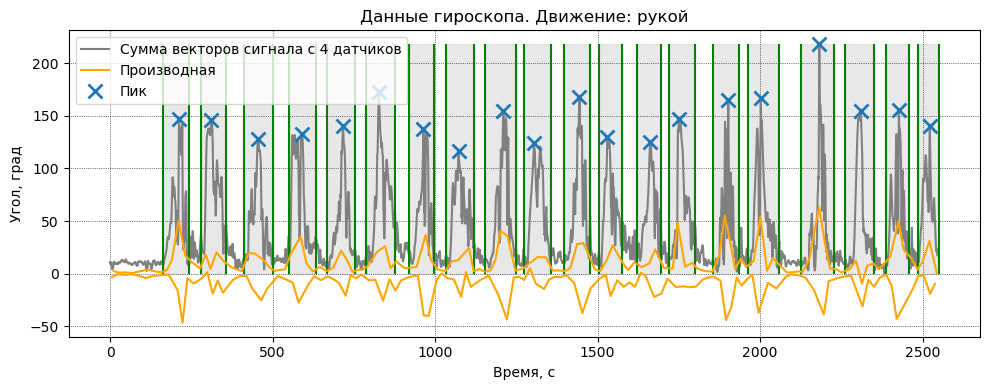

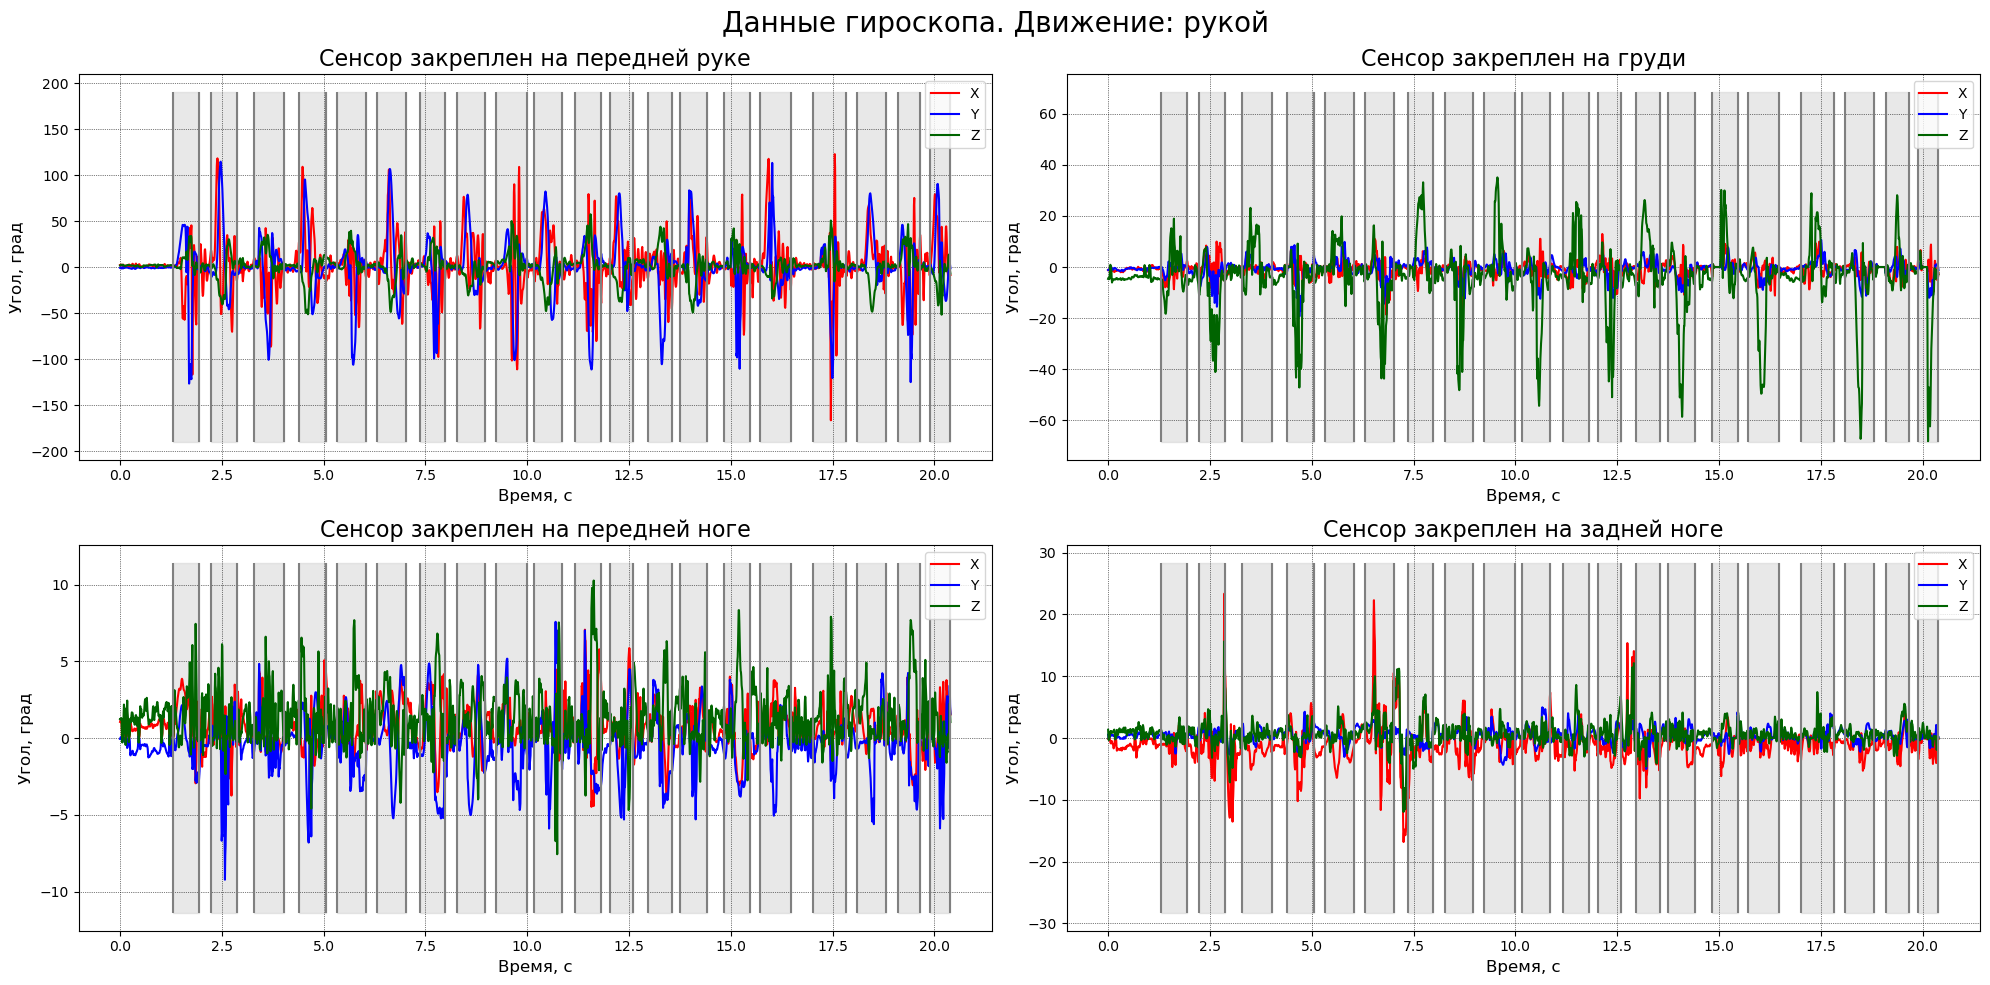

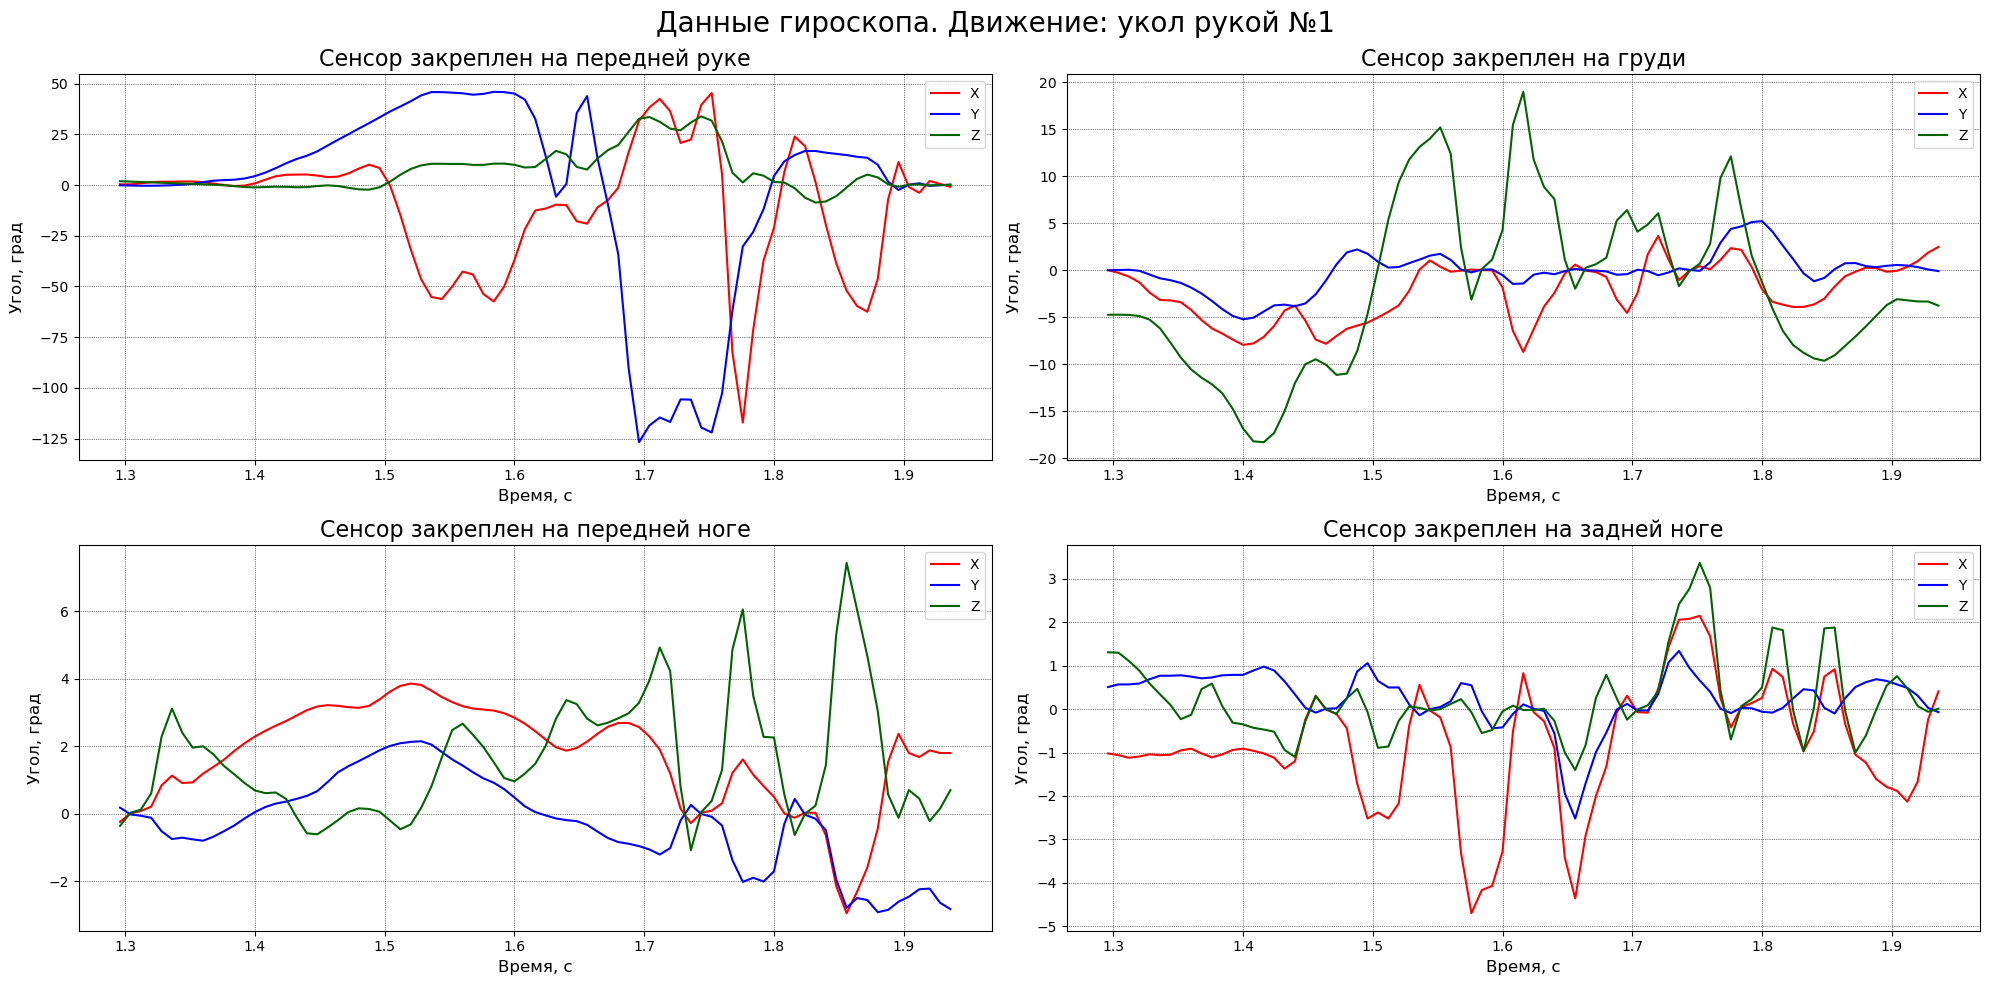

In [16]:
# название папок с движениями
moves = ['Arm/', 'Step/', 'Lunge/']
ways = ['укол', 'закрытие']
all_movement_dfs = []
all_params = []
peaks_executed = False
action_executed = False

for experimental in exp:
    for i, move in enumerate(moves):

        dfs = creation_of_dfs(way_folder, experimental, move)

        # Создание отсчета времени, используя частоту дискретизации устройства
        # Создание вектора по евклидовой норме
        t = np.arange(len(dfs[0]['x'])) / fs
        for df in dfs:
            df['t'] = t
            df['vector'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
            
        # Сигнал при движении рукой имеет сильный скачок, поэтому наобходимо обрезать сигнал
        if move == 'Arm/': 
            if experimental == 'Cherkasova_20_1/':
                for df in dfs:
                    df.drop(index=range(2550, len(df)), inplace=True) 
            if experimental == 'Zushko_18/':
                for df in dfs:
                    df.drop(index=range(3850, len(df)), inplace=True)         
            if experimental == 'Sugkoeva_17/':
                for b, df in enumerate(dfs):
                    dfs[b] = df.iloc[150:].reset_index(drop=True)



                
        combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, df_forward_ind, df_backward_ind = find_movement_peaks(dfs, move)
        if not peaks_executed:
            plot_peaks(way_folder, experimental, move, combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, fencing_move, i, save = save)
            plot_dfs(way_folder, experimental, move, dfs, fencing_move[i], body_part, start_indices, end_indices, save = save)
            peaks_executed = True
            
        """Для вывода всех пиков снять # """
#         plot_peaks(way_folder, experimental, move, combined_df, start_indices, end_indices, positive_peaks, negative_peaks, derivative, peaks, fencing_move, i, save = save)
#         plot_dfs(way_folder, experimental, move, dfs, fencing_move[i], body_part, start_indices, end_indices, save = save)
            
        # Разделение сигнала на отдельные движения и подсчет параметров для характеристики движения
        for n, df in enumerate([df_forward_ind, df_backward_ind]):
            for a in range(len(df)):
                movement_dfs = movement(dfs, df['start'][a], df['end'][a])
                all_movement_dfs.append(movement_dfs)
                #Для примера. Вывод графика одного движения и данные датчиков к нему
                if not action_executed:
                    plot_dfs(way_folder, experimental, move, movement_dfs, f'{ways[n]} {fencing_move[i]} №{a+1}', body_part, save = save)
                    action_executed = True
                    
                """Для вывода всех движений снять # """
#                 plot_dfs(way_folder, experimental, move, movement_dfs, f'{ways[n]} {fencing_move[i]} №{a+1}', body_part, save = save)
                    
                params = features(movement_dfs, f'{ways[n]} {fencing_move[i]} {a+1}', body_part, experimental)
                all_params.append(params)
            
# Объединение датафреймов в один 
A = pd.concat(all_params)

# Обработаем данные

### Cозданный общий датафрейм содержит в себе данные о всех сделанных движениях во время исследования, а также их параметры

In [17]:
print('Количество сделанных движений, количество параметров для 1 движения: ', A.shape)
A.head(8)

Количество сделанных движений, количество параметров для 1 движения:  (1656, 24)


25-й процентиль            \
                                                              x    y    z   
Фехтовальщик     Движение   Номер Датчик                                    
Cherkasova_20_1/ укол рукой 1     груди                    -4.4 -0.8 -8.8   
                                  задней ноге              -1.3  0.0 -0.3   
                                  передней ноге             0.8 -1.0  0.2   
                                  передней руке           -21.8 -0.4 -0.5   
                            2     груди                    -1.1 -0.5 -4.5   
                                  задней ноге              -2.5 -0.2 -0.1   
                                  передней ноге            -0.3 -1.1  0.1   
                                  передней руке           -24.7 -9.5 -0.1   

                                                75-й процентиль              \
                                                              x     y     z   
Фехтовальщик     Движение   Номер Датчик                                      
Cherkasova_20_1/ укол рукой 1     груди                     0.0   0.6   4.1   
                                  задней ноге               0.0   0.6   0.5   
                                  передней ноге             2.9   0.5   2.7   
                                  передней руке             5.0  25.0  10.4   
                            2     груди                     0.2   1.0   9.3   
                                  задней ноге              -0.8   1.0   1.0   
                                  передней ноге             0.5   0.3   2.2   
                                  передней руке             5.5  13.2  20.3   

                                                Максимум             Медиана  \
                                                       x     y     z       x   
Фехтовальщик     Движение   Номер Датчик                                       
Cherkasova_20_1/ укол рукой 1     груди              3.6   5.2  19.0    -2.0   
                                  задней ноге        2.2   1.3   3.4    -0.9   
                                  передней ноге      3.9   2.2   7.4     1.9   
                                  передней руке     45.3  45.9  33.8     0.0   
                            2     груди              3.8   6.0  23.2    -0.2   
                                  задней ноге        0.3   2.3   3.6    -1.6   
                                  передней ноге      4.3   4.8   6.6     0.0   
                                  передней руке     42.3  42.5  35.1    -5.0   

                                                 ... Минимум Отсчеты        \
                                                 ...       z       x     y   
Фехтовальщик     Движение   Номер Датчик         ...                         
Cherkasova_20_1/ укол рукой 1     груди          ...   -18.3    81.0  81.0   
                                  задней ноге    ...    -1.4    81.0  81.0   
                                  передней ноге  ...    -1.1    81.0  81.0   
                                  передней руке  ...    -8.6    81.0  81.0   
                            2     груди          ...   -10.9    91.0  91.0   
                                  задней ноге    ...    -1.8    91.0  91.0   
                                  передней ноге  ...    -1.0    91.0  91.0   
                                  передней руке  ...   -12.4    91.0  91.0   

                                                      Среднее            \
                                                    z       x    y    z   
Фехтовальщик     Движение   Номер Датчик                                  
Cherkasova_20_1/ укол рукой 1     груди          81.0    -2.3 -0.2 -2.0   
                                  задней ноге    81.0    -0.8  0.2  0.2   
                                  передней ноге  81.0     1.7 -0.3  1.6   
                                  передней руке  81.0   -10.4 -2.0  6.6   
                            2     груди          91.0    -0.5  0.

### Классы движений

In [18]:
unique_movements = list(A.index.get_level_values('Движение').unique())
unique_movements

['укол рукой',
 'закрытие рукой',
 'укол шагом',
 'закрытие шагом',
 'укол выпадом',
 'закрытие выпадом']

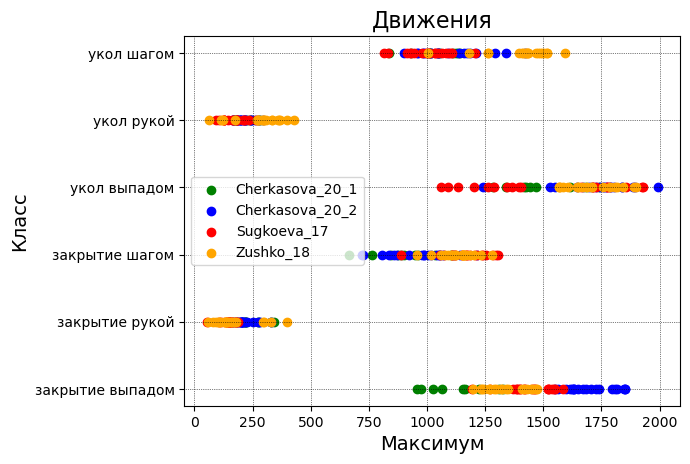

In [19]:
plt.figure()
prm = ['Отсчеты', 'Среднее', 'Стандартное отклонение', 'Минимум', '25-й процентиль', 'Медиана', '75-й процентиль', 'Максимум']
prmNum = 7
colors = ['green', 'blue', 'red', 'orange']
for i, color in zip(range(len(exp)), colors):
    Ai = A[A.index.get_level_values('Фехтовальщик') == exp[i]]
    values = Ai.loc[exp[i], :, :, :][prm[prmNum]]
    sum_values = values.groupby(['Номер', 'Движение']).sum().reset_index().set_index('Движение')
    sum_values = sum_values.drop('Номер', axis=1).sum(axis=1)
    plt.scatter(sum_values, sum_values.index, color=color, label=exp[i][:-1]) 
plt.xlabel(prm[prmNum], fontsize=14)
plt.ylabel('Класс', fontsize=14)
plt.title('Движения', fontsize=16)
plt.grid(which='major', linewidth=0.5, linestyle=':', color='k')
plt.legend()
if save == True:
    plt.savefig(f'Движения.png', dpi=400, bbox_inches='tight')
plt.show()


In [20]:
All_signs = A.reset_index().pivot_table(index=['Фехтовальщик', 'Движение', 'Номер'], columns=['Датчик'])
All_signs.columns = [f'{col[0]}_{col[1]}_{col[2]}' for col in All_signs.columns]
All_signs.reset_index(inplace=True)
All_signs = All_signs.drop(['Фехтовальщик','Номер'], axis = 1)
All_signs.head(8)

,Движение,25-й процентиль_x_груди,25-й процентиль_x_задней ноге,25-й процентиль_x_передней ноге,25-й процентиль_x_передней руке,25-й процентиль_y_груди,25-й процентиль_y_задней ноге,25-й процентиль_y_передней ноге,25-й процентиль_y_передней руке,25-й процентиль_z_груди,...,Стандартное отклонение_x_передней ноге,Стандартное отклонение_x_передней руке,Стандартное отклонение_y_груди,Стандартное отклонение_y_задней ноге,Стандартное отклонение_y_передней ноге,Стандартное отклонение_y_передней руке,Стандартное отклонение_z_груди,Стандартное отклонение_z_задней ноге,Стандартное отклонение_z_передней ноге,Стандартное отклонение_z_передней руке
0,закрытие выпадом,-5.3,-31.2,-4.2,-1.5,-1.8,-0.3,-0.4,-4.9,-14.5,...,15.9,17.1,11.4,29.8,97.1,13.0,15.3,38.4,27.3,8.5
1,закрытие выпадом,-3.0,-34.4,-4.0,-4.6,-2.7,-1.3,-2.5,-7.2,-17.4,...,18.2,23.7,13.1,32.2,105.6,15.3,16.1,48.2,56.3,13.3
2,закрытие выпадом,-3.2,-14.1,-7.0,0.0,-4.2,-4.2,-17.6,-18.3,-22.7,...,19.4,18.2,12.2,21.2,108.1,23.7,19.7,40.1,64.1,8.8
3,закрытие выпадом,-3.8,-33.4,-8.1,-5.8,-3.8,-0.4,0.1,-10.6,-16.1,...,16.4,30.9,11.1,28.7,96.2,22.7,16.9,50.6,52.7,9.2
4,закрытие выпадом,-4.0,-50.1,-7.5,-1.3,-11.8,-1.1,1.7,-7.8,-20.2,...,15.1,16.1,12.6,34.5,117.3,18.8,18.0,38.1,53.5,10.7
5,закрытие выпадом,-5.1,-46.7,-4.4,-2.4,-3.2,-0.8,-1.9,-7.3,-16.2,...,15.9,17.9,11.3,35.4,84.6,24.7,17.7,57.4,36.0,10.3
6,закрытие выпадом,-2.9,-41.6,-3.0,-6.7,-4.2,0.1,-0.6,-3.2,-14.4,...,14.4,24.0,13.3,36.5,96.3,18.0,25.3,58.3,38.9,6.7
7,закрытие выпадом,-2.8,-48.2,-4.9,-2.0,-2.8,0.5,0.0,-11.5,-19.3,...,16.8,25.0,9.0,40.7,110.6,26.1,15.1,60.6,37.7,8.9


# Решаем задачу классификации с учителем 

In [21]:
y = All_signs['Движение'] # Целевая переменная
X = All_signs.drop('Движение', axis = 1) # Матрица признаков

In [22]:
X.head()

,25-й процентиль_x_груди,25-й процентиль_x_задней ноге,25-й процентиль_x_передней ноге,25-й процентиль_x_передней руке,25-й процентиль_y_груди,25-й процентиль_y_задней ноге,25-й процентиль_y_передней ноге,25-й процентиль_y_передней руке,25-й процентиль_z_груди,25-й процентиль_z_задней ноге,...,Стандартное отклонение_x_передней ноге,Стандартное отклонение_x_передней руке,Стандартное отклонение_y_груди,Стандартное отклонение_y_задней ноге,Стандартное отклонение_y_передней ноге,Стандартное отклонение_y_передней руке,Стандартное отклонение_z_груди,Стандартное отклонение_z_задней ноге,Стандартное отклонение_z_передней ноге,Стандартное отклонение_z_передней руке
0,-5.3,-31.2,-4.2,-1.5,-1.8,-0.3,-0.4,-4.9,-14.5,-22.0,...,15.9,17.1,11.4,29.8,97.1,13.0,15.3,38.4,27.3,8.5
1,-3.0,-34.4,-4.0,-4.6,-2.7,-1.3,-2.5,-7.2,-17.4,-16.0,...,18.2,23.7,13.1,32.2,105.6,15.3,16.1,48.2,56.3,13.3
2,-3.2,-14.1,-7.0,0.0,-4.2,-4.2,-17.6,-18.3,-22.7,-9.3,...,19.4,18.2,12.2,21.2,108.1,23.7,19.7,40.1,64.1,8.8
3,-3.8,-33.4,-8.1,-5.8,-3.8,-0.4,0.1,-10.6,-16.1,-19.5,...,16.4,30.9,11.1,28.7,96.2,22.7,16.9,50.6,52.7,9.2
4,-4.0,-50.1,-7.5,-1.3,-11.8,-1.1,1.7,-7.8,-20.2,-20.7,...,15.1,16.1,12.6,34.5,117.3,18.8,18.0,38.1,53.5,10.7


In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 96 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   25-й процентиль_x_груди                 414 non-null    float64
 1   25-й процентиль_x_задней ноге           414 non-null    float64
 2   25-й процентиль_x_передней ноге         414 non-null    float64
 3   25-й процентиль_x_передней руке         414 non-null    float64
 4   25-й процентиль_y_груди                 414 non-null    float64
 5   25-й процентиль_y_задней ноге           414 non-null    float64
 6   25-й процентиль_y_передней ноге         414 non-null    float64
 7   25-й процентиль_y_передней руке         414 non-null    float64
 8   25-й процентиль_z_груди                 414 non-null    float64
 9   25-й процентиль_z_задней ноге           414 non-null    float64
 10  25-й процентиль_z_передней ноге         414 non-null    float6

In [24]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 414 entries, 0 to 413
Series name: Движение
Non-Null Count  Dtype 
--------------  ----- 
414 non-null    object
dtypes: object(1)
memory usage: 3.4+ KB


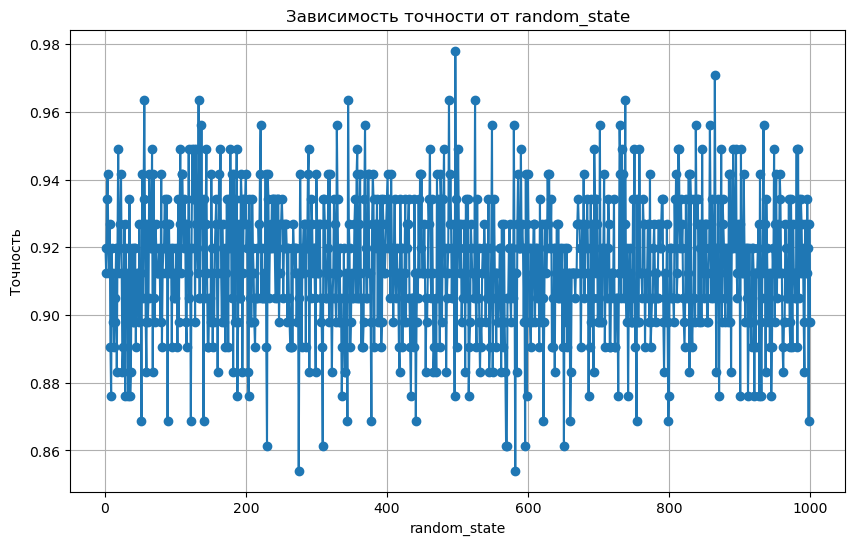

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

accuracies = []
for random_state in range(1, 1001):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Отрисовка графика
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1001), accuracies, marker='o')
plt.title('Зависимость точности от random_state')
plt.xlabel('random_state')
plt.ylabel('Точность')
plt.grid(True)
plt.show()

max_random_state = accuracies.index(max(accuracies)) + 1

### Рандомизируем выборку и разделим на тренировочную и тестовую выборки

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=max_random_state)

### Стандартизируем признаки

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Решим задачу классификации методом логистической регрессии

In [28]:
# Создание модели логистической регрессии
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Обучение модели на обучающей выборке
lr.fit(X_train, y_train)

# Прогнозирование классов для тестовых данных
y_pred = lr.predict(X_test)

# Прогнозирование классов для тренировочных данных
y_train_pred = lr.predict(X_train)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

Точность модели: 0.9781021897810219


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=unique_movements, digits=4))

                  precision    recall  f1-score   support

      укол рукой     1.0000    0.9545    0.9767        22
  закрытие рукой     0.9474    0.9474    0.9474        19
      укол шагом     0.9565    1.0000    0.9778        22
  закрытие шагом     1.0000    1.0000    1.0000        27
    укол выпадом     0.9565    0.9565    0.9565        23
закрытие выпадом     1.0000    1.0000    1.0000        24

        accuracy                         0.9781       137
       macro avg     0.9767    0.9764    0.9764       137
    weighted avg     0.9784    0.9781    0.9781       137



In [30]:
check_test = pd.DataFrame({
    'Фактическое': y_test,
    'Предсказанное': y_pred.flatten(),
})

check_test.sample(10)

,Фактическое,Предсказанное
174,укол шагом,укол шагом
329,закрытие рукой,закрытие рукой
336,закрытие шагом,закрытие шагом
154,укол рукой,укол рукой
66,закрытие выпадом,закрытие выпадом
306,закрытие выпадом,закрытие выпадом
393,укол рукой,укол рукой
286,укол шагом,укол шагом
400,укол шагом,укол шагом
150,укол рукой,укол рукой


## График сравнения фактических и предсказанных значений

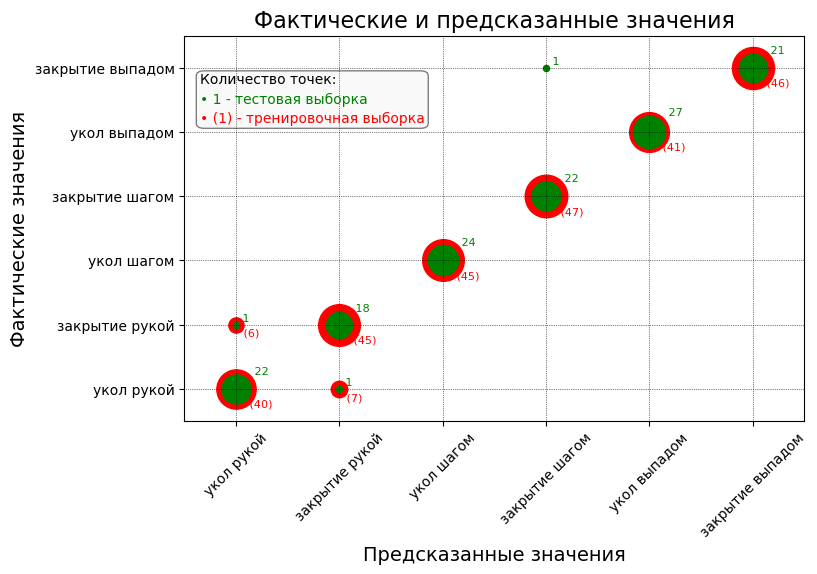

In [31]:
evaluate_preds(y_test, y_train, y_pred, y_train_pred, unique_movements, save = save)

# Решим задачу классификации методом случайного леса

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Диапазон количества деревьев для тестирования
n_estimators_range = [5, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# Список для хранения средних точностей
mean_accuracies = []

for n_estimators in n_estimators_range:
    # Создание модели случайного леса с заданным количеством деревьев
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Оценка модели с использованием кросс-валидации
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

    # Вычисление средней точности и добавление ее в список
    mean_accuracy = np.mean(scores)
    mean_accuracies.append(mean_accuracy)
    print(f"Количество деревьев: {n_estimators}, Средняя точность: {mean_accuracy}")

# Выбор количества деревьев с лучшей средней точностью
best_n_estimators = n_estimators_range[np.argmax(mean_accuracies)]
print(f"Лучшее количество деревьев: {best_n_estimators}")

Количество деревьев: 5, Средняя точность: 0.8736363636363637
Количество деревьев: 10, Средняя точность: 0.9136363636363637
Количество деревьев: 50, Средняя точность: 0.9061038961038962
Количество деревьев: 100, Средняя точность: 0.9133766233766234
Количество деревьев: 150, Средняя точность: 0.9097402597402597
Количество деревьев: 200, Средняя точность: 0.9097402597402597
Количество деревьев: 250, Средняя точность: 0.9097402597402597
Количество деревьев: 300, Средняя точность: 0.9061688311688311
Количество деревьев: 350, Средняя точность: 0.9098051948051948
Количество деревьев: 400, Средняя точность: 0.9061688311688311
Количество деревьев: 450, Средняя точность: 0.9133766233766234
Количество деревьев: 500, Средняя точность: 0.9061038961038962
Лучшее количество деревьев: 10


In [42]:
# Создание модели случайного леса
rf = RandomForestClassifier(n_estimators=best_n_estimators) 
# Обучение модели на обучающей выборке
rf.fit(X_train, y_train)

# Прогнозирование классов для тестовых данных
y_pred = rf.predict(X_test)

# Прогнозирование классов для тренировочных данных
y_train_pred = rf.predict(X_train)

# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

Точность модели: 0.9562043795620438


In [43]:
print(classification_report(y_test, y_pred, target_names=unique_movements, digits=4))

                  precision    recall  f1-score   support

      укол рукой     1.0000    1.0000    1.0000        22
  закрытие рукой     0.7917    1.0000    0.8837        19
      укол шагом     1.0000    1.0000    1.0000        22
  закрытие шагом     0.9643    1.0000    0.9818        27
    укол выпадом     1.0000    0.7826    0.8780        23
закрытие выпадом     1.0000    0.9583    0.9787        24

        accuracy                         0.9562       137
       macro avg     0.9593    0.9568    0.9537       137
    weighted avg     0.9641    0.9562    0.9561       137



In [39]:
check_test = pd.DataFrame({
    'Фактическое': y_test,
    'Предсказанное': y_pred.flatten(),
})

check_test.sample(10)

,Фактическое,Предсказанное
79,закрытие рукой,закрытие рукой
92,закрытие рукой,закрытие рукой
273,укол рукой,закрытие рукой
35,укол выпадом,укол выпадом
170,укол шагом,укол шагом
247,укол выпадом,укол выпадом
286,укол шагом,укол шагом
38,укол рукой,закрытие рукой
326,закрытие рукой,закрытие рукой
304,закрытие выпадом,закрытие выпадом


## График сравнения фактических и предсказанных значений

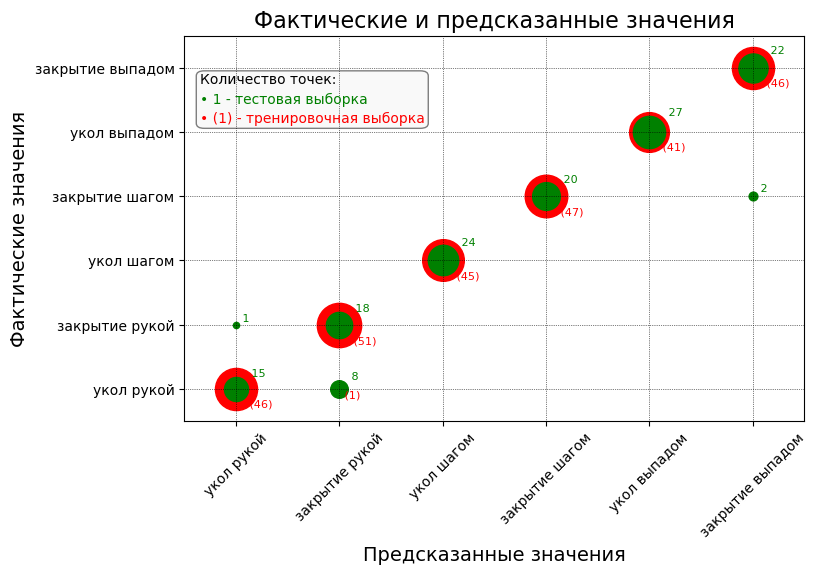

In [40]:
evaluate_preds(y_test, y_train, y_pred, y_train_pred, unique_movements, save = save)